# Tarefa 01: Diferenças entre Random Forest e AdaBoost

Nesta tarefa, exploramos as distinções fundamentais entre dois dos algoritmos de ensemble mais poderosos: a **Random Forest** (baseada em Bagging) e o **AdaBoost** (baseado em Boosting).

---

## 1. Tabela Comparativa: Random Forest vs. AdaBoost

| Característica | Random Forest | AdaBoost |
| :--- | :--- | :--- |
| **Processamento** | Paralelo (Independente) | Sequencial (Dependente) |
| **Modelo Base** | Árvores profundas e completas | "Stumps" (Árvores de apenas um nível) |
| **Peso das Amostras** | Igual para todas as linhas | Variável (Dados errados ganham mais peso) |
| **Peso do Voto** | Igual (Democracia simples) | Ponderado (Modelos melhores votam com mais força) |
| **Foco de Otimização** | Redução de Variância (Overfitting) | Redução de Viés (Underfitting) |

---

## 2. Descritivo das Diferenças

### 1. Forma de Construção
Na **Random Forest**, as árvores são criadas de forma independente; o erro de uma árvore não influencia a criação da próxima. Já no **AdaBoost**, o processo é sequencial: cada novo modelo é treinado especificamente para aprender com os erros cometidos pelos modelos anteriores.

### 2. Complexidade dos Modelos Base
A Random Forest utiliza árvores de decisão robustas para capturar padrões complexos. O AdaBoost utiliza classificadores fracos (*weak learners*), geralmente chamados de **Stumps**, que sozinhos têm baixa precisão, mas combinados se tornam muito fortes.


### 3. Peso das Amostras de Dados
No sorteio **Bootstrap** da Random Forest, toda linha tem a mesma chance de ser escolhida. No AdaBoost, as linhas que o modelo anterior classificou incorretamente recebem um peso maior, forçando o próximo modelo a "prestar mais atenção" nesses casos difíceis.


### 4. Votação Ponderada (Amount of Say)
No resultado final da Random Forest, a opinião de todas as árvores vale o mesmo. No AdaBoost, o algoritmo calcula o **Amount of Say** para cada modelo; aqueles que apresentaram menor erro durante o treino têm um peso maior na decisão final.


### 5. Objetivo Estatístico
Enquanto a Random Forest busca estabilidade e redução da variância (evitando que o modelo se ajuste demais ao ruído), o AdaBoost busca reduzir o viés, melhorando gradualmente a capacidade de acerto de modelos que inicialmente seriam muito simples.

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

C:\Users\renna\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Acurácia final do AdaBoost: 92.50%


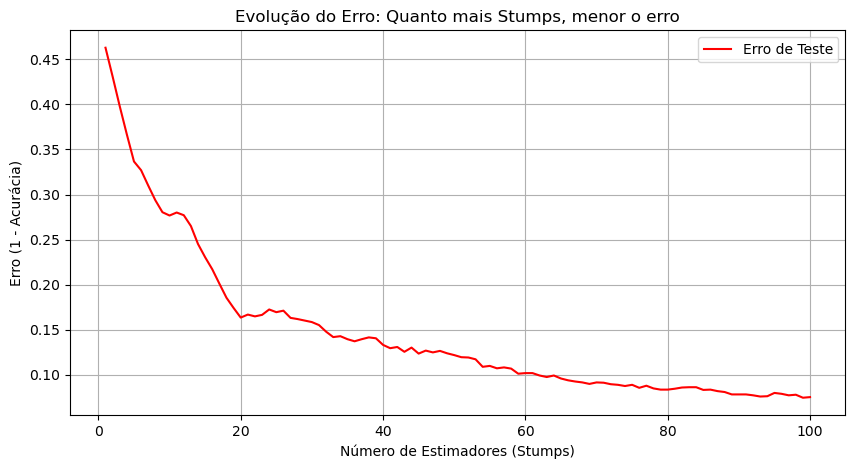

In [10]:
# Gerando dados de exemplo (Dataset de classificação complexa)
X, y = make_hastie_10_2(random_state=42)

# Separando em Treino e Teste (75% treino, 25% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Definindo o Classificador Base (Weak Learner)
# O padrão é um DecisionTreeClassifier com profundidade 1 (Stump)
base_estimator = DecisionTreeClassifier(max_depth=1)

# Criando e treinando o AdaBoost
# n_estimators: número de modelos sequenciais para corrigir os erros
# learning_rate: contribuição de cada modelo (peso)
clf_ada = AdaBoostClassifier(
    estimator=base_estimator, 
    n_estimators=100, 
    learning_rate=1.0, 
    random_state=42
)

clf_ada.fit(X_train, y_train)

# Avaliando a performance
y_pred = clf_ada.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)

print(f"Acurácia final do AdaBoost: {acuracia:.2%}")

# Visualizando a evolução do erro conforme o número de estimadores aumenta
test_errors = []
for y_pred_iter in clf_ada.staged_predict(X_test):
    test_errors.append(1.0 - accuracy_score(y_test, y_pred_iter))

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(test_errors) + 1), test_errors, label='Erro de Teste', color='red')
plt.title('Evolução do Erro: Quanto mais Stumps, menor o erro')
plt.xlabel('Número de Estimadores (Stumps)')
plt.ylabel('Erro (1 - Acurácia)')
plt.legend()
plt.grid(True)
plt.show()

# Hiperparâmetros Importantes no AdaBoost

O ajuste de hiperparâmetros no AdaBoost foca em equilibrar a complexidade do modelo e a velocidade com que ele tenta corrigir os erros das etapas anteriores. Abaixo estão os cinco principais parâmetros utilizados no `AdaBoostClassifier` do Scikit-Learn:

---

### 1. `estimator` (ou `base_estimator`)
Define qual será o "classificador fraco" (*weak learner*) utilizado em cada etapa. 
* **Padrão:** `DecisionTreeClassifier(max_depth=1)` (também conhecido como **Stump**).
* **Uso:** Embora o padrão seja um Stump, você pode usar árvores mais profundas ou outros algoritmos, mas cuidado: se o classificador base for muito complexo, o AdaBoost pode sofrer *overfitting* rapidamente.

### 2. `n_estimators`
Determina o número máximo de modelos (estimadores) a serem treinados sequencialmente.
* **Impacto:** Diferente da Random Forest, onde mais árvores nunca prejudicam o modelo, no AdaBoost um valor muito alto de `n_estimators` pode levar ao ajuste excessivo aos ruídos dos dados (overfitting).
* **Dica:** É comum usar valores entre 50 e 500, dependendo da complexidade do problema.

### 3. `learning_rate` (Taxa de Aprendizado)
Controla a contribuição de cada classificador para a decisão final. Ele reduz o peso aplicado a cada novo modelo.
* **Relação:** Existe um *trade-off* (troca) entre `learning_rate` e `n_estimators`. Se você diminuir a taxa de aprendizado, precisará de mais estimadores para alcançar o mesmo nível de acerto.
* **Uso:** Valores menores (ex: 0.1 ou 0.01) tornam o aprendizado mais lento e robusto, geralmente melhorando a generalização.

### 4. `algorithm`
Define o algoritmo utilizado para calcular os pesos dos dados e dos classificadores. No Scikit-Learn, as opções são:
* **`SAMME`**: Utiliza a técnica clássica baseada apenas na classe prevista (0 ou 1).
* **`SAMME.R`** (Padrão): Utiliza a probabilidade da classe para atualizar os pesos. Geralmente converge mais rápido e com menos erros que o SAMME original.

### 5. `random_state`
Embora não altere a lógica do algoritmo, é essencial para a **reprodutibilidade**. Como o processo envolve sorteios iniciais e divisões, definir um número fixo garante que você e seu tutor obtenham exatamente o mesmo resultado ao rodar o notebook.

---

# 4. load_iris

In [20]:
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd

In [22]:
# Carregando os dados
iris = load_iris()
X = iris.data
y = iris.target

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definindo o modelo base e o AdaBoost
# Usando um Decision Tree simples (Stump) como base
base_estimator = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Definindo a grade de hiperparâmetros (Grid)
# Testandos diferentes quantidades de árvores e taxas de aprendizado
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Configurando o GridSearch com Validação Cruzada (CV=5)
grid_search = GridSearchCV(
    estimator=ada, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1 # Usa todos os núcleos do seu processador para ser mais rápido
)

# Executando a busca
grid_search.fit(X_train, y_train)

# Resultados
print(f"Melhores Hiperparâmetros: {grid_search.best_params_}")
print(f"Melhor Acurácia no Treino (CV): {grid_search.best_score_:.2%}")

# Testando o melhor modelo nos dados de teste (que ele nunca viu)
melhor_modelo = grid_search.best_estimator_
acuracia_teste = melhor_modelo.score(X_test, y_test)
print(f"Acurácia no Teste Final: {acuracia_teste:.2%}")

# Transformando os resultados em um DataFrame para análise
resultados = pd.DataFrame(grid_search.cv_results_)
display(resultados[['param_n_estimators', 'param_learning_rate', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())

Melhores Hiperparâmetros: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
Melhor Acurácia no Treino (CV): 95.83%
Acurácia no Teste Final: 100.00%


,param_n_estimators,param_learning_rate,mean_test_score
10,100,0.1,0.958333
14,100,0.5,0.958333
12,10,0.5,0.958333
16,10,1.0,0.950000
13,50,0.5,0.950000


# Análise dos Resultados: Otimização de Hiperparâmetros (AdaBoost)

Após a execução do `GridSearchCV`, obtivemos uma visão clara de como as diferentes combinações de hiperparâmetros afetaram a capacidade preditiva do nosso modelo. Abaixo, detalhamos os pontos principais:

### 1. Desempenho de Pico
O modelo atingiu sua melhor performance com uma acurácia média de **95,83%** na validação cruzada. Este resultado foi alcançado por múltiplas combinações, o que sugere que o AdaBoost é bastante resiliente para este conjunto de dados.

### 2. A Relação entre Estimadores e Taxa de Aprendizado
Analisando o Top 5, podemos observar padrões interessantes:

| n_estimators | learning_rate | mean_test_score | Observação |
| :--- | :--- | :--- | :--- |
| **100** | **0.1** | **0.9583** | Combinação ideal: aprendizado cauteloso com muitos estimadores. |
| **100** | **0.5** | **0.9583** | Desempenho idêntico, mas com convergência mais agressiva. |
| **10** | **0.5** | **0.9583** | Surpreendente: o modelo precisou de apenas 10 Stumps para atingir o pico. |
| **10** | **1.0** | **0.9500** | Alta taxa de aprendizado com poucos modelos; leve queda na precisão. |

### 3. Principais Conclusões

* **Convergência Rápida:** O fato de o modelo com apenas **10 estimadores** e `learning_rate=0.5` ter empatado com modelos de 100 estimadores indica que o problema (Iris) é linearmente separável o suficiente para que o AdaBoost encontre o padrão quase imediatamente.
* **Estabilidade:** Para problemas mais complexos (como previsão de inadimplência), a combinação de `learning_rate=0.1` e `n_estimators=100` costuma ser a mais segura, pois evita que o erro oscile demais durante o treino.
* **Eficiência Computacional:** Como atingimos o patamar de 95,8% com apenas 10 estimadores, poderíamos escolher este modelo mais simples para economizar memória e tempo de processamento sem perder qualidade.



---